# Single Slice Image Registration with Visualization

__Purpose:__ A notebook for checking the registration of problem slices

*Step 1: Import necessary packages*

In [1]:
import os

from glob import glob

import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from numpy.linalg import inv
import ifmodels

%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


*Step 2: Reading in the image*

In [3]:
for row in file_names.itertuples():
    try:
        #  Downloading the slice to be registered (moving image)
        file_id = row.ids
        new_file_name = row.names
        file6 = drive.CreateFile({'id': file_id})
        file6.GetContentFile(new_file_name)

        #  Cleaning up the moving image and getting registration points
        im = register.im_read(new_file_name)
        binary = register.mim_edge_detector(im)
        binary = register.image_cleaning(binary)
        coor_df = register.find_points(binary)

        #  Getting the proper atlas slice an its registration points
        slice = corr_atlas.loc[corr_atlas['Slidetag'] == new_file_name[:-4]].values.tolist()[0]
        slice_number = slice[1]
        sagittal, coronal, horizontal = register.atlas_slice(F_im_nii, slice_number)
        resized = preprocess.resize(coronal, 20)
        resized = register.mim_edge_detector(resized)
        fim_coor_df = register.find_points(resized)
    
        #  Performing the affine transformation to get registration coordinates
        df = pd.concat([coor_df, fim_coor_df], axis = 1)
        ainv = register.reg_coefficients(df, 1, 3, 5)

        #  Registering the slice
        registered_im = register.registration(im, ainv)
        Registered_stack[k] = registered_im
    
        #  Removing the downloaded file and printing file name as a status update
        os.remove(new_file_name)
        k = k + 1
        print(k, new_file_name)
    
    except:
        print("error " + str(IOError) + new_file_name)

NameError: name 'file_names' is not defined

In [4]:
im3 = io.imread('/Volumes/imagereg/6-26-19-tiffexport/test3.tif')

*Step 3: Seperating the color stack of the image*

In [5]:
red3 = im3[:, :, :, 0]
green3 = im3[:, :, :, 1]
blue3 = im3[:, :, :, 2]

*Step 4: Taking the max intensity projection of the stacks*

In [6]:
im_max_3= np.max(blue3, axis=0)

*Step 5: Visualizng the slice as a checkpoint*

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Local Threshold Cell Image at T=0')
ax1.imshow(binary_local, cmap='gray')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Global Threshold Cell Image at T=0')
ax2.imshow(binary_global, cmap='gray')

fig.set_size_inches(18.5, 10.5, forward=True)

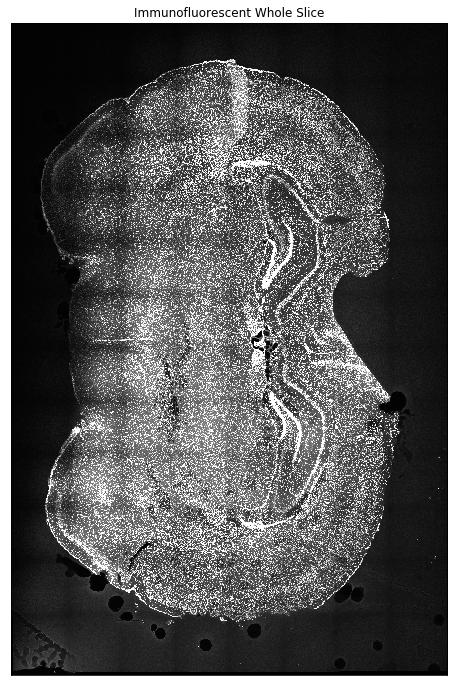

In [12]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.imshow(im_max_3, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Immunofluorescent Whole Slice')

fig.set_size_inches(10, 12, forward=True)
fig.savefig('pic2.png')

*Step 6: Creating a dataframe of the image registration coordinates for moxing (M) and Fixed (F) images*

In [11]:
dfM = pd.read_csv('/Volumes/imagereg/6-26-19-tiffexport/M_regPoints_csv')
dfF = pd.read_csv('/Volumes/imagereg/6-26-19-tiffexport/F_regPoints_csv')

In [12]:
df = pd.concat([dfM, dfF], axis = 1)

In [13]:
df

,M_x,M_y,F_x,F_y
0,287,1822,283,1609
1,1695,3141,1689,2896
2,3383,3225,2389,2914
3,4968,1756,3833,1569
4,3985,264,3029,502
5,1464,239,1089,502


*Step 7: Performing the Linear Algebra for Affine Transformation Coefficients*

In [14]:
row1 = 0

In [15]:
X = np.array([[df.iloc[row1][0], df.iloc[row1][1], 1], [df.iloc[3][0], df.iloc[3][1], 1], [df.iloc[4][0], df.iloc[4][1], 1]])

In [16]:
X_prime = np.array([df.iloc[0][2], df.iloc[3][2], df.iloc[4][2]])

In [17]:
Y_prime =  np.array([df.iloc[0][3], df.iloc[3][3], df.iloc[4][3]])

In [18]:
a,b,c = np.linalg.solve(X, X_prime)
d,e,f = np.linalg.solve(X,Y_prime)

*Step 8: Inverting Affine Transform matrix*

In [19]:
#The transform command below requires the inverse of the affine transformation matrix to work

In [20]:
#Creating a numpy matrix of the values calculated above

In [21]:
ax = np.array([[a, b, c], [d, e, f], [0, 0, 1]])

In [22]:
ax

array([[ 7.58932774e-01,  3.88532728e-02, -5.60436917e+00],
       [ 1.52391923e-03,  7.14143423e-01,  3.07393318e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [23]:
#Getting the inverse

In [24]:
ainv = inv(ax)

In [25]:
#Saving the coefficients as individual variabels to be fed into the transformation function

In [26]:
inva = ainv[0][0]
invb = ainv[0][1]
invc = ainv[0][2]
invd = ainv[1][0]
inve = ainv[1][1]
invf = ainv[1][2]

*Step 9: Peforming the actual Transform*

In [27]:
#Creating an Image object so that the transform function can be used

In [28]:
im = Image.fromarray(im_max_3)

In [29]:
atlas_size = (3200, 4280)

In [30]:
im12 = im.transform(atlas_size, Image.AFFINE, (inva, invb, invc, invd, inve, invf), resample=Image.NEAREST)

In [31]:
#Changing the image back into a numpy array

In [32]:
np_im12 = np.array(im12)

In [33]:
#Showing the registered image

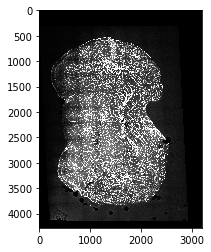

In [34]:
plt.imshow(np_im12, cmap = 'gray')


*Next Steps*
1. Make all the images the same size (insuring that the bran is in the center ofall of them)
2. Putting all the images into a .nii file
3. Creating an efficient process for registerinag multiple slices at once
4. Preprocessing clean up o fthe image so that bubbles and other noise are gone

In [35]:
#Checking homology of the transformations and registration error 

In [36]:
from skimage.measure import compare_ssim

In [37]:
im12 = im.transform(im.size, Image.AFFINE, (inva, invb, invc, invd, inve, invf), resample=Image.NEAREST)

In [38]:
hom_im12 = np.array(im12)

In [39]:
#Closer to 1 is better - but I don't know if this is affected by the fact that the image has been resized 
s = compare_ssim(im_max_3, hom_im12)
s

0.617902392166092

In [40]:
hom_X = np.array([[df.iloc[0][2], df.iloc[0][3], 1], [df.iloc[3][2], df.iloc[3][3], 1], [df.iloc[4][2], df.iloc[4][3], 1]])

In [41]:
hom_X_prime = np.array([df.iloc[0][0], df.iloc[3][0], df.iloc[4][0]])

In [42]:
hom_Y_prime =  np.array([df.iloc[1][1], df.iloc[3][1], df.iloc[4][1]])

In [43]:
homa,homb,homc = np.linalg.solve(hom_X, hom_X_prime)
homd,home,homf = np.linalg.solve(hom_X,hom_Y_prime)

In [44]:
hom_ax = np.array([[homa, homb, homc], [homd, home, homf], [0, 0, 1]])

In [45]:
hom_ax

array([[ 1.31778372e+00, -7.16945767e-02,  2.94237803e+01],
       [-3.71233321e-01,  1.67804273e+00,  5.46088281e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [46]:
ainv

array([[ 1.31778372e+00, -7.16945767e-02,  2.94237803e+01],
       [-2.81203452e-03,  1.40043194e+00, -4.30499179e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])